# Clustering

Clustering is _unsupervised learning_: we don't have answers available (or at least we analyze the data as if the answers are unavailable). We will apply methods to divide the data into subsets (called clusters).

Our first example will be a dataset built into Scikit-learn, the Wisconsin breast cancer diagnosis dataset.

Cells from healthy and malignant tissues were extracted using biopsy, and photographed through a microscope. The cells in these images were then segmented semi automatically using a method called snakes. Once the boundaries of the cells were found, these were used to calculate cell features, such as mean radius, area and texture. Statistics were calculated about the cells in each specimen, such as mean, standard error and the extreme value. [Street et al.: Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993] This is an example of traditional hand crafted feature extraction from the images. The most modern algorithms now learn relevant features directly from images using convolutional neural networks. We also have ground truth labels with diagnosis of cancer, so we can use this dataset for supervised classification learning, but in this notebook we will primarily focus in discovering underlying structure in the feature space.

In [1]:
# Imports
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import requests

In [2]:
# This code will download the required data files from GitHub
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'SirTurtle'
    repo = 'ML-BME-UofA-data'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
import os
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-5-Unsupervised-learning-and-dimensionality-reduction/data/slice.p', 'temp/slice.p')

In [3]:
bc = datasets.load_breast_cancer()

print('\n Features: \n', bc.feature_names)
print('\n Labels: ', bc.target_names)

# Feature matrix
X = bc.data

# Label vector
y = bc.target
print('\n We have {} features.'.format(X.shape[1]))


 Features: 
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

 Labels:  ['malignant' 'benign']

 We have 30 features.


We will first use `PCA` on our 30-dimensional dataset. PCA is a dimensionality reduction method and is useful to visualise the structure of high-dimensional datasets. We will use PCA to reduce the feature vector to 2 components. This will make it easier to visualize the results of our clustering, but we could use the full 30 features. Another alternative would be to select two features, but with PCA we have two components that capture as much of the variability of the features as possible.

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [4]:
# Plotting helper function
def PlotBreastCancerData(X, y, labels=['malignant', 'benign'], symbols=['r*', 'bo']):

    n = len(np.unique(y))
    for i in range(0, n):
        plt.plot(X[y==i,0], X[y==i,1], symbols[i], alpha=0.5, label=labels[i])
    
    # Annotate
    plt.legend()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Wisconsin Breast Cancer Dataset')
    
    plt.show()

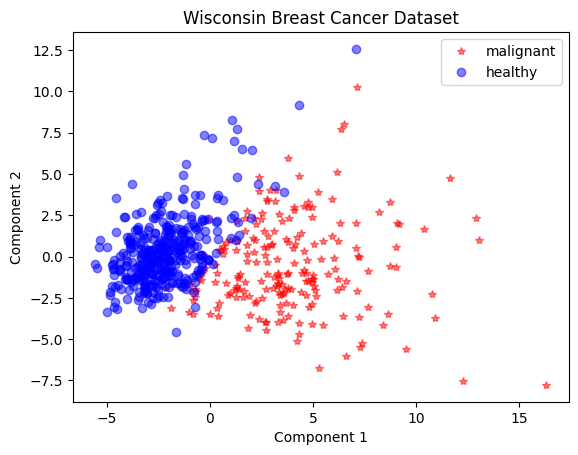

In [5]:
# Apply standard scaler to the feature matrix
X = StandardScaler().fit_transform(X)

# Create PCA feature transformer with 2 components
model = PCA(n_components = 2)

# Transform features using PCA
X_pca = model.fit_transform(X)

# Plot the transformed data
PlotBreastCancerData(X_pca, y, ['malignant', 'healthy'], ['r*', 'bo'])

For clustering, we will treat the data as if the labels are unknown.

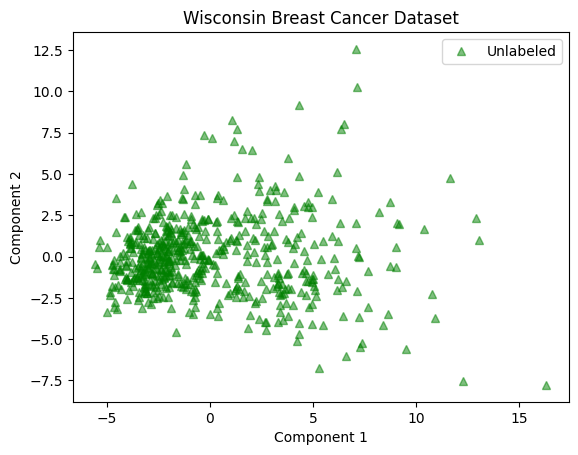

In [6]:
# Plot unlabeled dataset
PlotBreastCancerData(X_pca, np.zeros(len(y)), ['Unlabeled'], ['g^'])

### K-means clustering

Let's cluster the dataset using K-means and see how it well it can distinguish natural clusters in the dataset and whether these clusters correspond to the healthy and cancerous cells. We will tell K-means to find two clusters.

[KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

How well did our clustering algorithm perform? I.e., to what extent do our clusters correspond to the two classes (benign and malignant)? We can answer that with the accuracy_score method. We could also use other scores, e.g. recall. Note that the assignment by K-means of labels 0 and 1 to the two classes is arbitrary, so we will need to find the scores for both possible combinations. The higher score will be the measure of the performance of the model.

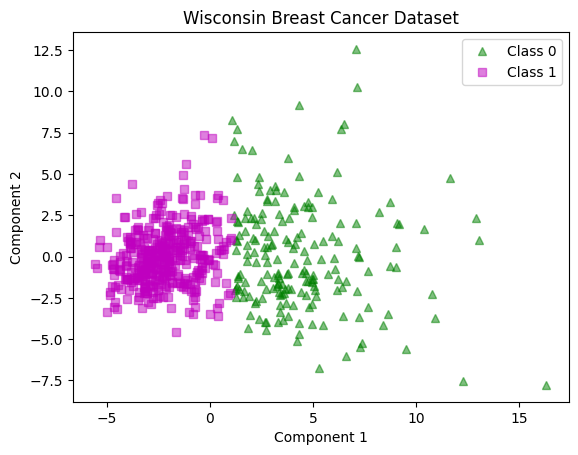

Accuracy score: 0.907


In [7]:
def KMeansCluster(X, y):

    # Create k-means model with 2 clusters
    km_model = KMeans(n_clusters=2, n_init=10)
    # n_init is the number of times the k-means algorithm is run with different centroid seeds

    # Fit the model and predict the labels
    km_y_pred = km_model.fit_predict(X_pca)

    PlotBreastCancerData(X_pca, km_y_pred, ['Class 0', 'Class 1'], ['g^', 'ms'])
    
    # Print out accuracy score compared to ground truth labels
    km_accuracy = np.max([accuracy_score(y, km_y_pred), accuracy_score(y, 1 - km_y_pred)])
    print('Accuracy score: {:.3f}'.format(km_accuracy))

KMeansCluster(X, y)

## Gaussian Mixture

Let's compare the k-means model with the gaussian mixture model.

[GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

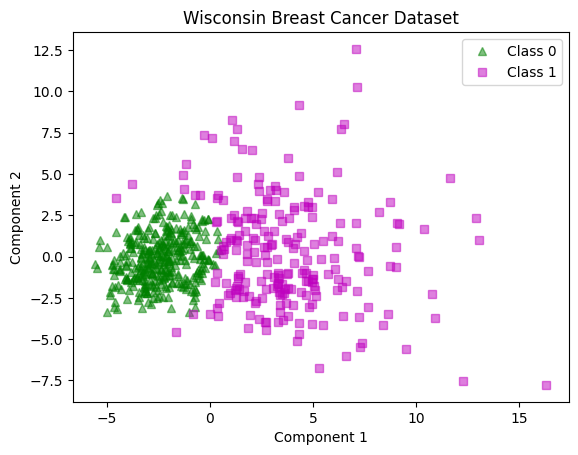

Accuracy score: 0.905


In [8]:
def GaussianMixtureCluster(X, y):

    # Create gaussian mixture model with 2 clusters
    gm_model = GaussianMixture(n_components=2)

    # Fit the model and predict the labels
    gm_y_pred = gm_model.fit_predict(X_pca)

    PlotBreastCancerData(X_pca, gm_y_pred, ['Class 0', 'Class 1'], ['g^', 'ms'])
    
    # Print out accuracy score compared to ground truth labels
    accuracy = np.max([accuracy_score(y, gm_y_pred), accuracy_score(y, 1 - gm_y_pred)])
    print('Accuracy score: {:.3f}'.format(accuracy))

GaussianMixtureCluster(X, y)

The shape of the clusters changed, but the accuracy was about the same.

## Spectral Clustering

Next, we will try clustering the same dataset using spectral clustering.

[SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

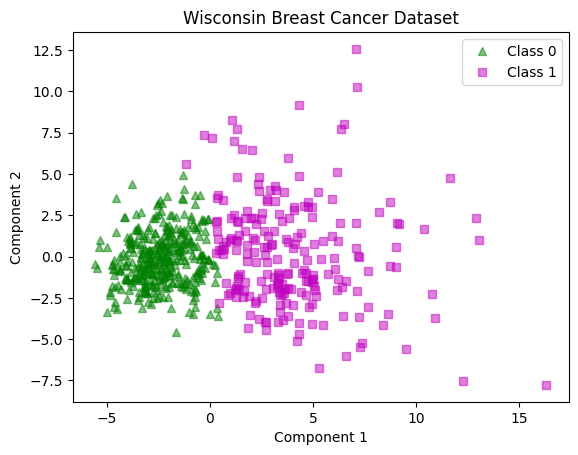

Accuracy score: 0.903


In [9]:
def SpectralCluster(X, y):

    # Create gaussian mixture model with 2 clusters
    sc_model = SpectralClustering(n_clusters=2, n_components=2, affinity='nearest_neighbors')

    # Fit the model and predict the labels
    sc_y_pred = sc_model.fit_predict(X_pca)

    PlotBreastCancerData(X_pca, sc_y_pred, ['Class 0', 'Class 1'], ['g^', 'ms'])
    
    # Print out accuracy score compared to ground truth labels
    accuracy = np.max([accuracy_score(y, sc_y_pred), accuracy_score(y, 1 - sc_y_pred)])
    print('Accuracy score: {:.3f}'.format(accuracy))

SpectralCluster(X_pca, y)

## Exercise 1
### Segmentation of brain MRI using Gaussian Mixture
Our 2D brain MRI image is saved in a pickle format as 'slice.p'. The non-brain tissue has been removed and the image has been padded with zeros. When performing GMM clustering to segment the white matter (WM), grey matter (GM) and cerebrospinal fluid (CSF), we will need to exclude the zero values for the algorithm to work well.

Run the code below to load and plot the brain MRI slice.

Slice dimensions:  (229, 193)


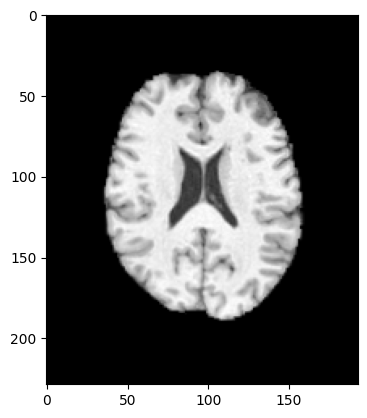

In [10]:
import pickle
mri_slice = pickle.load(open( "temp/slice.p", "rb" ))
print('Slice dimensions: ',mri_slice.shape)

plt.imshow(mri_slice)
plt.set_cmap('gray')

Let's now first plot the histogram of this image. We see the large peak of zero values which is the padding of the background.

*Note: we use* `_=plt.hist` *because we do not want the histogram values to be printed.*

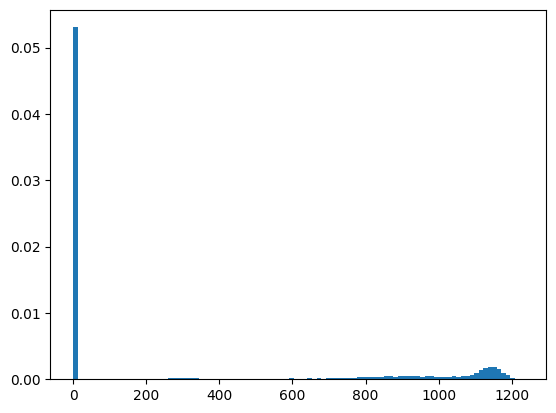

In [11]:
# display histogram
_=plt.hist(mri_slice.flatten(), bins = 100, density = True)

We need to exclude the padding to make the GMM segmentation work well. We therefore select only non-zero elements and plot histogram of these. This can be done using function `np.where` (otherwise, `mri_slice>0` is fine too). Note that `slice2`, which contains the selected pixels is now a 1D array.

Can you recognise the peaks of WM, GM and CSF?

Shape of selected data is  (15340,)


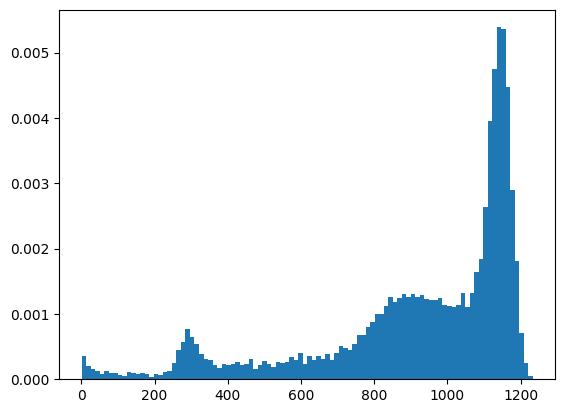

In [12]:
# Find indices of non-zero elements
ind = np.where(mri_slice>0)

# Select non-zero elements
slice2 = mri_slice[ind]

# Check the dimension
print('Shape of selected data is ', slice2.shape)

# Plot histogram
_=plt.hist(slice2, bins = 100, density = True)

__Task 1.1:__ Now perform clustering of `slice2` using `GaussianMixture`. Set number of clusters to `3` and random state to `42` to get the same result every time you rerun it.
Perform the following tasks:
* Create the `GaussianMixture` model
* Create the feature matrix `X` by reshaping `slice2` into 2D array
* Fit the model and predict the labels
* Reshape the predicted labels to the original shape of `mri_slice`
* Display using `imshow`

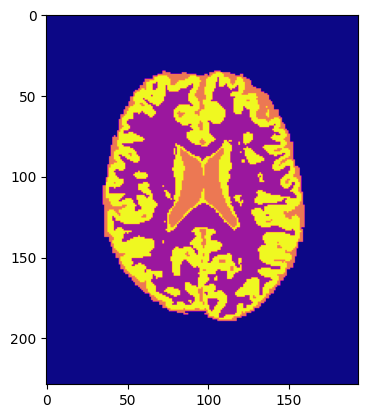

In [13]:
from sklearn.mixture import GaussianMixture

# Create the GaussianMixture model
model=GaussianMixture(n_components=3, random_state=42)

# Create the feature matrix X by reshaping slice2 into 2D array
X = slice2.reshape(-1,1)

# Fit the model and predict the cluster labels
y_pred = model.fit_predict(X)

# Create array of 2D labels:
# Reshape the predicted labels to the original shape of mri_slice
labels2D = np.zeros(mri_slice.shape)
# Put the labels into fields with non-zero indices
labels2D[ind]=y_pred+1

# Display the label image
plt.imshow(labels2D)
plt.set_cmap('plasma')

**Task 1.2:** Predict the probabilistic segmentations for each tissue class.  Display the maps in a figure with three subplots.

To do that perform the following steps:
* Predict the probabilistic segmentations using function `predict_proba`
* Check the size of the resulting predicted probability matrix
* Write a `for` loop over the tissue types
* Select the probability map for the current class from the predicted probability matrix
* Create an array of zeros the same shape as `mri_slice`
* Insert the class-dependent probability into the right locations in this array
* Display the array using `subplot` and `imshow`

In [14]:
# Predict posterior probabilities
proba = model.predict_proba(X)

# Check the dimensions
print('Dimensions of proba ', proba.shape)

Dimensions of proba  (15340, 3)


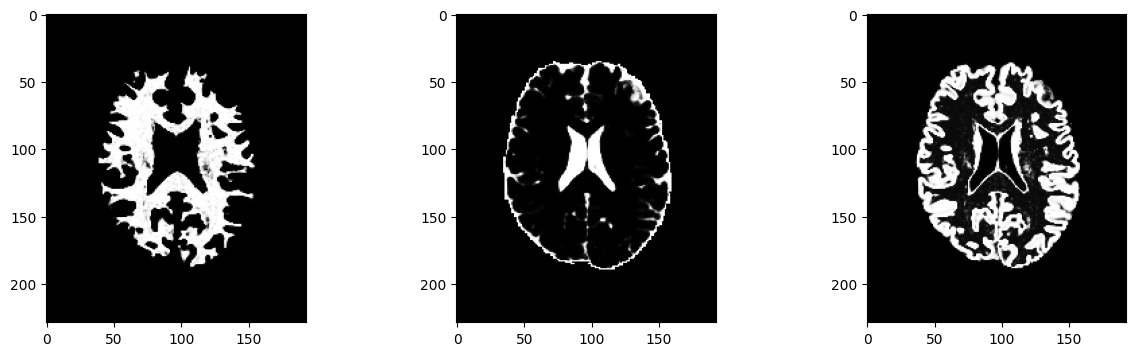

In [15]:
# Display
plt.figure(figsize = [15,4])
plt.set_cmap('gray')

for i in range(3):
    # Take only posteriors for class i
    post = proba[:,i]

    # Reshape to the 3D image:
    # Create an array of zeros the same shape as mri_slice
    post2D = np.zeros_like(mri_slice)
    # Insert the class-dependent probability into the right locations in this array
    post2D[ind] = post
    
    # Display
    plt.subplot(1,3,i+1)
    plt.imshow(post2D)

## Exercise 2 (optional)

### Explore Gaussian Mixture model

In this exercise we will explore the theoretical concepts of Gaussian mixture models, including **likelihoods** and **posteriors**. We will use the `GaussianMixture` model that we fitted to perform segmentation of brain MRI in Exercise 2.

### Posterior probabilities

Probabilistic segmentation $p_{ik}$ gives us probability that pixel $i$ to belong the class $k$. These are in fact **posterior probabilities** $$p(z_i=k|x_i, \mu_k, \sigma_k,c_k)$$ for the labels $z_i$ given the intensity value $x_i$ and parameters $\mu_k, \sigma_k,c_k$ of the Gaussian intensity distribution for class $k$.

**Task 2.1:** Now let's plot how posterior probability for each class varies with pixel intensity value.  Fill in the missing code below to display the probability curves.

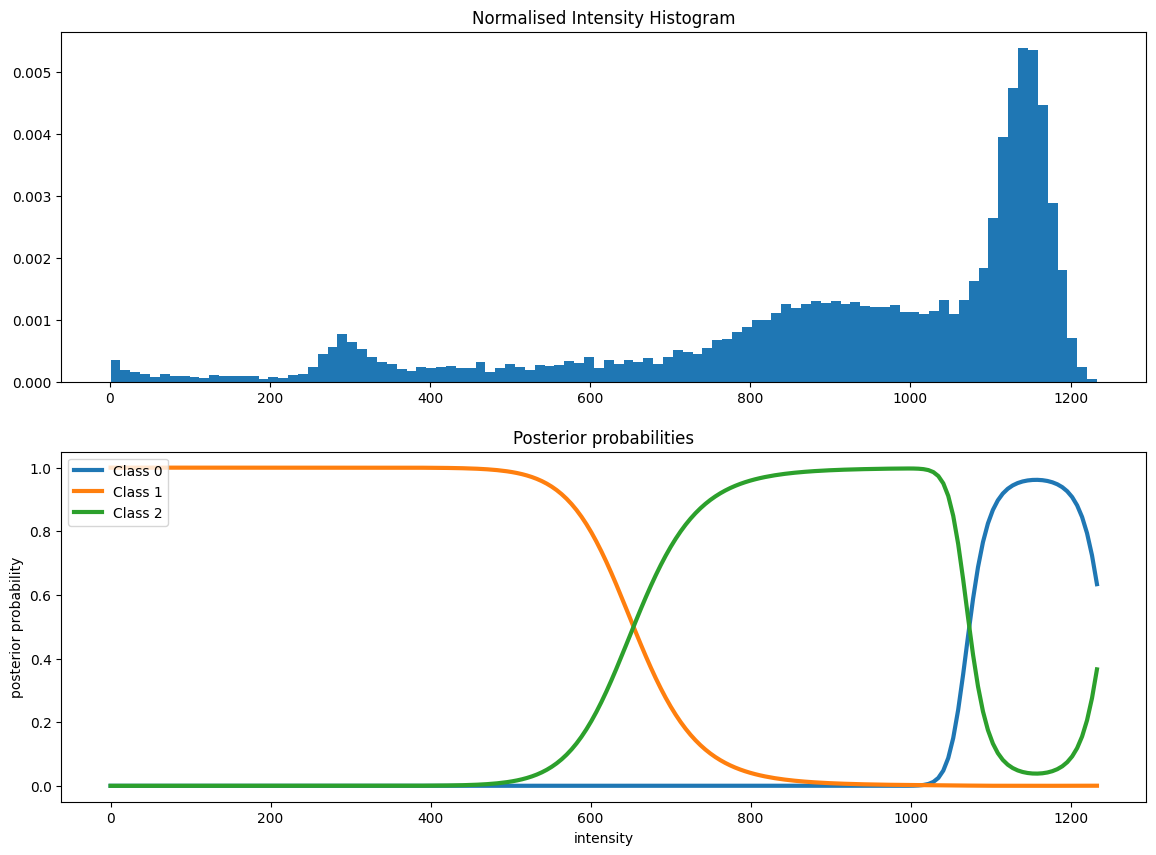

In [16]:
# Pixel intensity value range
intensity_range = np.linspace(0, np.max(slice2),200)

# Predict posterior probabilities for the intensity range
# (Do not forget to reshape the intensity range to 2D array for the prediction!)
proba_curves = model.predict_proba(intensity_range.reshape(-1,1))

# Display
plt.figure(figsize = [14,10])

# Plot normalised histogram
# The normalisation is achieved by parameter density
plt.subplot(211)
_=plt.hist(slice2, bins = 100, density = True)
plt.title('Normalised Intensity Histogram')

# Plot posterior probabilities in a for loop
plt.subplot(212)
for i in range(0,3):
    plt.plot(intensity_range, proba_curves[:,i], linewidth = 3, label = 'Class {}'.format(i))

# Annotate the subplot
plt.title('Posterior probabilities')
plt.xlabel('intensity')
plt.ylabel('posterior probability')
plt.legend(loc = 'upper left')
plt.show()

### Class-dependent likelihood

Class-dependent likelihoods are modelled by Gaussian distributions scaled by the mixing proportions
$$p(x_i|z_i=k,\mu_k,\sigma_k, c_k)=G(x_i,\mu_k,\sigma_k)c_k$$ 

To display these distributions over the normalised histogram (notice parameter `density=True`) we need to extract the `means_`, `covariances_` and `weights_` from the fitted `model`. Then we need to calculate the Gaussian distributions for these parameters. To do that we use function `norm.pdf` from `scipy.stats` module. Finally, these distributions need to be multiplied by the weights and plotted.

**Task 2.2:** Plot the Gaussian intensity distributions for each class $k$ over the normalised image histogram. To do that, fill in the missing code below and run the cell.

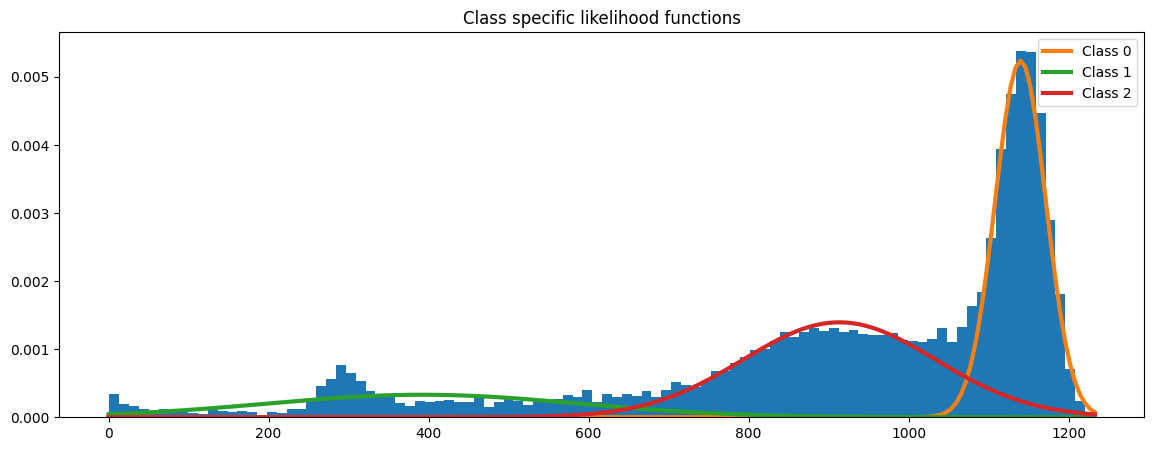

In [17]:
# To calculate gaussian distribution
from scipy.stats import norm

# Get parameters of GMM:
# Means
m = model.means_.flatten()  # Use flatten to make 1D arrays

# Standard deviation
s = np.sqrt(model.covariances_).flatten()

# Mixing proportions
w = model.weights_.flatten()

# Display
plt.figure(figsize = [14,5])

# Histogram
_=plt.hist(slice2, bins = 100, density = True)

# Class-dependent likelihoods - Gaussian PDFs
for i in range(0,3):
    likelihood = w[i]*norm.pdf(intensity_range, m[i], s[i])
    plt.plot(intensity_range, likelihood, linewidth = 3, label = 'Class {}'.format(i))
plt.legend()
plt.title('Class specific likelihood functions')
plt.show()

### Likelihood

The likelihood for each pixel intensity $x_i$ given the Gaussian Mixture Model parameters $\phi = (\mu_k,\sigma_k,c_k),k=1,...,K$ can be evaluated as
$$p(x_i|\phi)=\sum_{k=1}^KG(x_i,\mu_k,\sigma_k)c_k $$

We can calculate this function by adding the class-dependent likelihoods together. The alternative is to use a function provided by `GaussianMixture` model `score_samples` that returns **log-likelihood**.

**Task 2.3:** Plot the likelihood function for the whole intensity range over the normalised image histogram. To do that, first evaluate log-likelihood over the intensity range, then calculate the exponential using `np.exp` and then plot it.

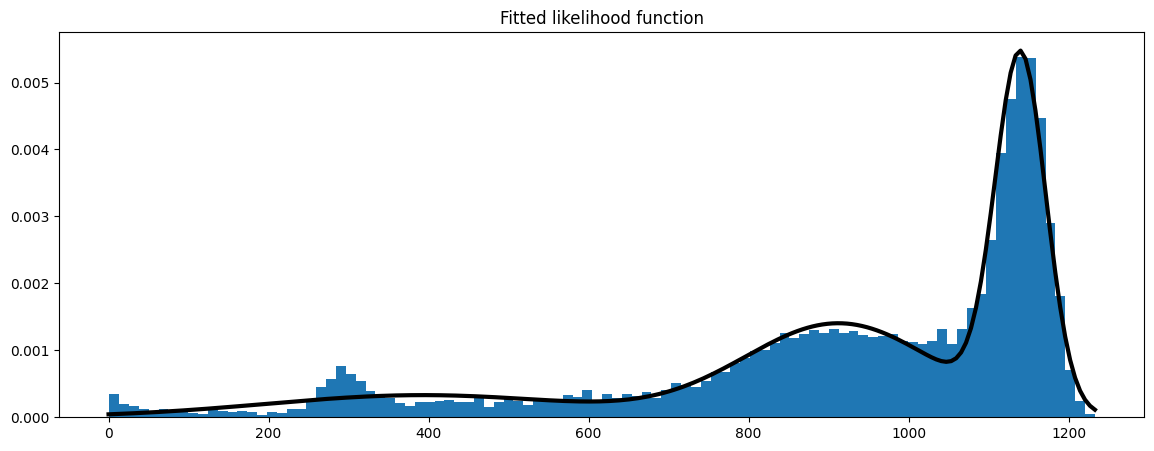

In [18]:
# Compare histogram with fitted Gaussian mixture likelihood function
plt.figure(figsize = [14,5])

# Histogram
h2 = plt.hist(slice2, bins = 100, density = True)

# Calculate likelihood
likelihood = np.exp(model.score_samples(intensity_range.reshape(-1,1)))

# Plot likelihood
plt.plot(intensity_range, likelihood, linewidth = 3, c='k')
plt.title('Fitted likelihood function')
plt.show()